# Investigating HTAN scRNA-seq with BigQuery

```
Title:   Accessing HTAN scRNA-seq with BigQuery and building Scanpy AnnData objects.
Author:  David L Gibbs (david.gibbs@systemsbiology.org)
Created: 2022-3-29
Purpose: Building AnnData objects
URL:     
Notes:  
```

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer MoonshotSM initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ( [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469).

This notebook shows examples of how HTAN single cell RNA sequencing data can be accessed and analyzed using Python.

### 1.1 Goal

The goal of this notebook is to show the user how HTAN data can queried for cells content and gene expression.

### 1.2 Inputs, Outputs, & Data

Inputs for this analysis include: HTAN Level 3 (gene summarized) single cell RNA sequncing results.



# 2. Environment & Module Setup

In [2]:
# GCP Libraries
from google.cloud import bigquery
#from google.colab import auth

# Data Analytics
import numpy as np
from scipy import stats
from scipy import sparse
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see 'Quick Start Guide to ISB-CGC' and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

In [ ]:
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()
# alternatively, use the gcloud SDK
#!gcloud auth application-default login

In [20]:
## Setup ##

# set the google project that will be billed for this notebook's computations
google_project = 'my_project'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

/opt/miniconda3/envs/nb/lib/python3.10/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [21]:
# Center figures
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 4. Querying data from BigQuery

By accessing the HTAN-joined tables, we have cell, gene, and count data combined into one table.

Let's start with looking at the number of samples per patient and number of cells per patient.


### 4.1 Samples and Cells Per Participant

In [5]:
# first to get the number of samples per patient

df1 = client.query("""
  SELECT
    patient,
    count(distinct(batch)) samples,
    count(distinct(Cell)) num_cells
  FROM
    `htan-dcc.adata_myeloid_010920.X_obs_var_join`
  GROUP BY 1
  ORDER BY num_cells DESC # ASC # or DESC
    """).result().to_dataframe()

df1[0:10]

,patient,samples,num_cells
0,RU682,2,2554
1,RU675,2,2073
2,RU1170,3,774
3,RU255,1,644
4,RU685,1,633
5,RU1124,1,608
6,RU661,1,560
7,RU1134,2,487
8,RU1065,1,477
9,RU699,1,422


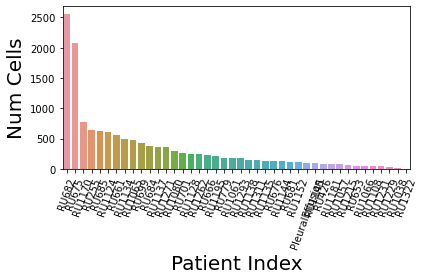

In [6]:
plt.rcParams['figure.figsize'] = [12, 8]

p = sns.barplot(x=df1.patient, y=df1.num_cells)
p.set_xlabel("Patient Index", fontsize = 20)
p.set_ylabel("Num Cells", fontsize = 20)
plt.xticks(rotation=70)
plt.tight_layout()


So there's a range of how many cells were sequenced in each sample and some patients have multiple samples, RU1170 has three samples (batches), let's focus on those. What kind of samples are available?

In [7]:
# first to get the number of samples per patient

df2 = client.query("""
  SELECT
    patient,
    batch,
    count(distinct(Cell)) cells
  FROM
    `htan-dcc.adata_myeloid_010920.X_obs_var_join`
  WHERE
    patient = 'RU1134'
  GROUP BY patient, batch
    """).result().to_dataframe()

df2

,patient,batch,cells
0,RU1134,RU1134-CN2,143
1,RU1134,RU1134_Sort-Freeze,344


Interesting, so there's a number of cells per sample (batch) where it looks like protocol order was being tested. Let's see what the annotation tells us about cells within these batches.

In [8]:
# first to get the number of samples per patient

df3 = client.query("""
  SELECT
    patient,
    batch,
    tissue, 
    treatment, 
    procedure, 
    cell_type,
    clusters,
    histo,
    count(distinct(Cell)) num_cells,
    count(distinct(index)) num_genes,
    AVG(total_counts) avg_total_counts

  FROM
    `htan-dcc.adata_myeloid_010920.X_obs_var_join`
  WHERE
    batch = 'RU1134_Sort-Freeze' 
  GROUP BY 1,2,3,4,5,6,7,8
    """).result().to_dataframe()

df3

,patient,batch,tissue,treatment,procedure,cell_type,clusters,histo,num_cells,num_genes,avg_total_counts
0,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,cDC,14,LUAD,26,10949,23153.584763
1,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,Mo/Mφ,6,LUAD,183,14002,17003.091393
2,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,cDC,5,LUAD,57,12698,23814.779908
3,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,Mo/Mφ,10,LUAD,6,1445,1533.993688
4,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,pDC,15,LUAD,10,8086,13033.528426
5,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,Mo/Mφ,16,LUAD,12,8177,12767.233968
6,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,Mo/Mφ,19,LUAD,1,1687,6243.000000
7,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,Mo/Mφ,1,LUAD,7,4315,4047.123993
8,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,Mo/Mφ,11,LUAD,29,4179,1535.424551
9,RU1134,RU1134_Sort-Freeze,lung,Platinum Doublet,Resection,Mo/Mφ,8,LUAD,5,3759,5541.849234


Ok, so we see that these cells are primarily Macrophages and dendritic cells (DCs) from the lung, but they fall into a number of different clusters. There are a smaller number of clusters that contain most of the cells and all the cells have been aquired using the same procedure after treatment.  Let's make a plot!

[Text(0.5, 1.0, 'RU1170g_Freeze-Sort')]

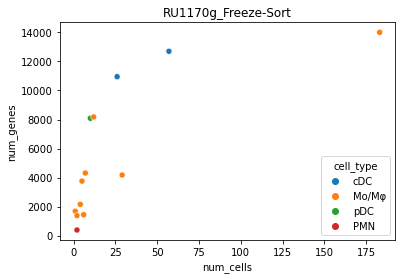

In [9]:
sns.scatterplot(data=df3, x='num_cells', y='num_genes', hue='cell_type').set(title='RU1170g_Freeze-Sort')

### 4.2 Compare monocyte gene expression among clusters

To continue, let's compare the gene expression between Mo/Mφ in clusters 16 vs 6.  To start with, let's get gene expression for these cells and look at the high expressing genes.

In [10]:
# first to get the number of samples per patient

df4 = client.query("""
  SELECT
    batch,
    clusters,
    count(distinct(Cell)) as num_cells_C6,
    index as gene, 
    AVG(X_value) as avg_counts_C6
  FROM
    `htan-dcc.adata_myeloid_010920.X_obs_var_join`
  WHERE
    batch = 'RU1134_Sort-Freeze' and
    tissue = 'lung' and
    cell_type = 'Mo/Mφ' and 
    clusters = 6
  GROUP BY 1,2,4
  ORDER BY avg_counts_C6 DESC
  LIMIT 10
    """).result().to_dataframe()

df4

,batch,clusters,num_cells_C6,gene,avg_counts_C6
0,RU1134_Sort-Freeze,6,183,FTH1,8.218318
1,RU1134_Sort-Freeze,6,183,FTL,7.226197
2,RU1134_Sort-Freeze,6,183,LYZ,6.779811
3,RU1134_Sort-Freeze,6,183,B2M,6.725721
4,RU1134_Sort-Freeze,6,183,HLA-DRA,6.621716
5,RU1134_Sort-Freeze,6,183,ACTB,6.555078
6,RU1134_Sort-Freeze,6,183,TPT1,6.319609
7,RU1134_Sort-Freeze,6,183,SRGN,6.318309
8,RU1134_Sort-Freeze,6,183,CD74,6.258437
9,RU1134_Sort-Freeze,6,183,VIM,6.105739


What do the expression counts look like for one cell here?  Let's pick out one cell and look across it's expression.

[Text(0.5, 1.0, 'RU1134_Sort-Freeze_201542926744819, Gene Counts')]

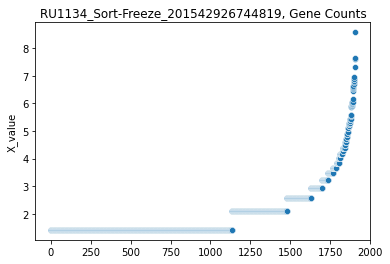

In [11]:
# first to get the number of samples per patient

df4_1 = client.query("""
  SELECT
    batch,
    clusters,
    Cell,
    index as gene, 
    X_value
  FROM
    `htan-dcc.adata_myeloid_010920.X_obs_var_join`
  WHERE
    batch = 'RU1134_Sort-Freeze' and
    tissue = 'lung' and
    cell_type = 'Mo/Mφ' and 
    clusters = 6 and 
    Cell = 'RU1134_Sort-Freeze_201542926744819'
  GROUP BY 1,2,3,4,5
  ORDER BY X_value ASC
    """).result().to_dataframe()

sns.scatterplot(data=df4_1, x=df4_1.index, y='X_value').set(title='RU1134_Sort-Freeze_201542926744819, Gene Counts')

I think we can see that these counts are certainly log transformed, and possibly normalized.

Let's see what the mean differences are between cluster 16 and 6.

In [12]:
# first to get the number of samples per patient

df5 = client.query("""

SELECT
  A.batch,
  A.gene,
  A.avg_counts_C16,
  B.avg_counts_C6,
  A.avg_counts_C16 - B.avg_counts_C6 as mean_diff
FROM (
  SELECT
    batch,
    INDEX AS gene,
    AVG(X_value) AS avg_counts_C16
  FROM
    `htan-dcc.adata_myeloid_010920.X_obs_var_join`
  WHERE
    batch = 'RU1170g_Freeze-Sort'
    AND tissue = 'lung'
    AND cell_type = 'Mo/Mφ'
    AND clusters = 16
  GROUP BY
    1,
    2 ) AS A
INNER JOIN (
  SELECT
    batch,
    INDEX AS gene,
    AVG(X_value) AS avg_counts_C6
  FROM
    `htan-dcc.adata_myeloid_010920.X_obs_var_join`
  WHERE
    batch = 'RU1170g_Freeze-Sort'
    AND tissue = 'lung'
    AND cell_type = 'Mo/Mφ'
    AND clusters = 6
  GROUP BY
    1,
    2 ) AS B
ON
  A.batch = B.batch
  AND A.gene = B.gene

GROUP BY 1,2,3,4
ORDER BY mean_diff DESC
LIMIT 200

    """).result().to_dataframe()

df5

,batch,gene,avg_counts_C16,avg_counts_C6,mean_diff
0,RU1170g_Freeze-Sort,BMP2,3.428054,0.742353,2.685701
1,RU1170g_Freeze-Sort,LAMP3,2.933397,0.623930,2.309467
2,RU1170g_Freeze-Sort,GDF15,3.261792,1.059851,2.201941
3,RU1170g_Freeze-Sort,FCGR3A,4.135931,2.112109,2.023822
4,RU1170g_Freeze-Sort,PEBP4,2.777788,0.856318,1.921470
...,...,...,...,...,...
195,RU1170g_Freeze-Sort,TUBA1A,2.777784,2.105401,0.672383
196,RU1170g_Freeze-Sort,LIN52,1.226290,0.554424,0.671866
197,RU1170g_Freeze-Sort,WAC,2.360655,1.689191,0.671464
198,RU1170g_Freeze-Sort,RP11-488C13.5,1.544391,0.874343,0.670048


<AxesSubplot:ylabel='mean_diff'>

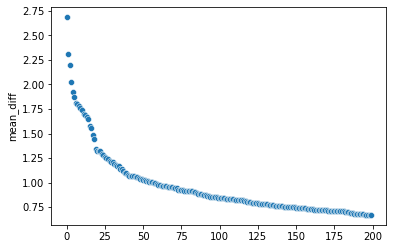

In [13]:
sns.scatterplot(data=df5, x=range(0,200), y='mean_diff')

"The role of BMP2 in macrophages is unknown and remains an area of active research. BMP2 has been reported to be constitutively expressed in M1 (inflammatory) macrophages" (https://www.nature.com/articles/s41598-018-37329-5)

In this notebook we explored the data, drilled down into a single sample (batch) and within that sample, compared the gene expression of macrophages that lie in the two largest macrophage clusters.

# 5. Relevant Citations and Links


[HTAN Portal](https://humantumoratlas.org/)   


[Overview paper, Cell, April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)

